In [2]:
import os, numpy as np, matplotlib.pyplot as plt, pandas as pd, sklearn.model_selection, tensorflow as tf
from PIL import Image
from json import dumps
from tensorflow import keras


dataset_path = "../notMNIST_large"
img_size = 28
px_depth = 255.0

# 1. Dataset preparation

## 1.1. Dataset loading

In [3]:
def load_letter(path, imgs_count = None):
    img_names = os.listdir(path)
    max_processed_imgs_count = imgs_count if imgs_count is not None else len(img_names)
    res_dataset = []

    processed_img_idx = 0
    while processed_img_idx < max_processed_imgs_count:
        img_name = img_names[processed_img_idx]
        img_path = os.path.join(path, img_name)
        try:
            img_data = Image.open(img_path)
            img_table = np.array(img_data) / px_depth
            img_row = np.reshape(img_table, img_table.shape[0]*img_table.shape[1], order='C')
            res_dataset += [img_row]
            processed_img_idx = processed_img_idx + 1
        except (IOError, ValueError) as e:
            print('Could not read:', img_path, ':', e, '! File will be skipped.')

    print(path, 'Full dataset tensor: ', len(res_dataset))
    return res_dataset


def load_datasets(path, imgs_count = None):
    folder_paths = os.listdir(path)
    res_letter_dataset = None
    res_label_dataset = None

    for folder_path in folder_paths:
        cur_letter_dataset = load_letter(path + "/"  + folder_path, imgs_count)
        cur_label_dataset = [folder_path] * len(cur_letter_dataset)

        res_letter_dataset = cur_letter_dataset if res_letter_dataset is None \
            else (res_letter_dataset + cur_letter_dataset)

        res_label_dataset = cur_label_dataset if res_label_dataset is None \
            else (res_label_dataset + cur_label_dataset)

    return res_letter_dataset, res_label_dataset


x, y =  load_datasets(dataset_path, 8000)

../notMNIST_large/A Full dataset tensor:  8000
../notMNIST_large/B Full dataset tensor:  8000
../notMNIST_large/C Full dataset tensor:  8000
../notMNIST_large/D Full dataset tensor:  8000
../notMNIST_large/E Full dataset tensor:  8000
../notMNIST_large/F Full dataset tensor:  8000
../notMNIST_large/G Full dataset tensor:  8000
../notMNIST_large/H Full dataset tensor:  8000
../notMNIST_large/I Full dataset tensor:  8000
../notMNIST_large/J Full dataset tensor:  8000


## 1.2. Samples dividing and duplicates deleting

In [4]:
def get_array_without_idxs(sample, deleted_idx_list):
    unique_sample = [i for j, i in enumerate(sample) if j not in deleted_idx_list]
    return unique_sample


def get_unique_sample(x, y):
    img_array_strings = [dumps(row.tolist()) for row in x]

    data = {'letter': y,
            'img_array': x,
            'img_array_string': img_array_strings}
    df = pd.DataFrame.from_dict(data)
    df = df.reset_index()

    bool_series = df['img_array_string'].duplicated(keep = 'first')
    duplicates = df[bool_series]
    duplicate_idx_list = duplicates['index'].tolist()

    unique_x = get_array_without_idxs(x, duplicate_idx_list)
    unique_y = get_array_without_idxs(y, duplicate_idx_list)

    return unique_x, unique_y

In [5]:
def get_samples(x, y, train_sample_count, validation_sample_count, test_sample_count):
    total_count = len(x)

    sample_count = train_sample_count + validation_sample_count + test_sample_count

    rest_x, sample_x, rest_y, sample_y = sklearn.model_selection.train_test_split(
        x, y, test_size=sample_count/total_count, random_state=42)

    train_x, test_validation_x, train_y, test_validation_y = sklearn.model_selection.train_test_split(
        sample_x, sample_y, test_size=(validation_sample_count + test_sample_count)/sample_count, random_state=42)

    validation_x, test_x, validation_y, test_y = sklearn.model_selection.train_test_split(
        test_validation_x, test_validation_y, test_size=test_sample_count/(validation_sample_count + test_sample_count), random_state=42)
    return train_x, train_y, validation_x, validation_y, test_x, test_y

train_x, train_y, validation_x, validation_y, test_x, test_y = get_samples(x, y, 50000, 10000, 19000)

old_len = len(train_y)
train_x, train_y = get_unique_sample(train_x, train_y)
print(f'There was {old_len - len(train_y)} duplicates in train sample')

old_len = len(validation_y)
validation_x, validation_y = get_unique_sample(validation_x, validation_y)
print(f'There was {old_len - len(validation_y)} duplicates in validation sample')

old_len = len(test_y)
test_x, test_y = get_unique_sample(test_x, test_y)
print(f'There was {old_len - len(test_y)} duplicates in test sample')

There was 4091 duplicates in train sample
There was 274 duplicates in validation sample
There was 742 duplicates in test sample


## 1.3. Check are classes balanced

Variance for train sample is: 19747.69


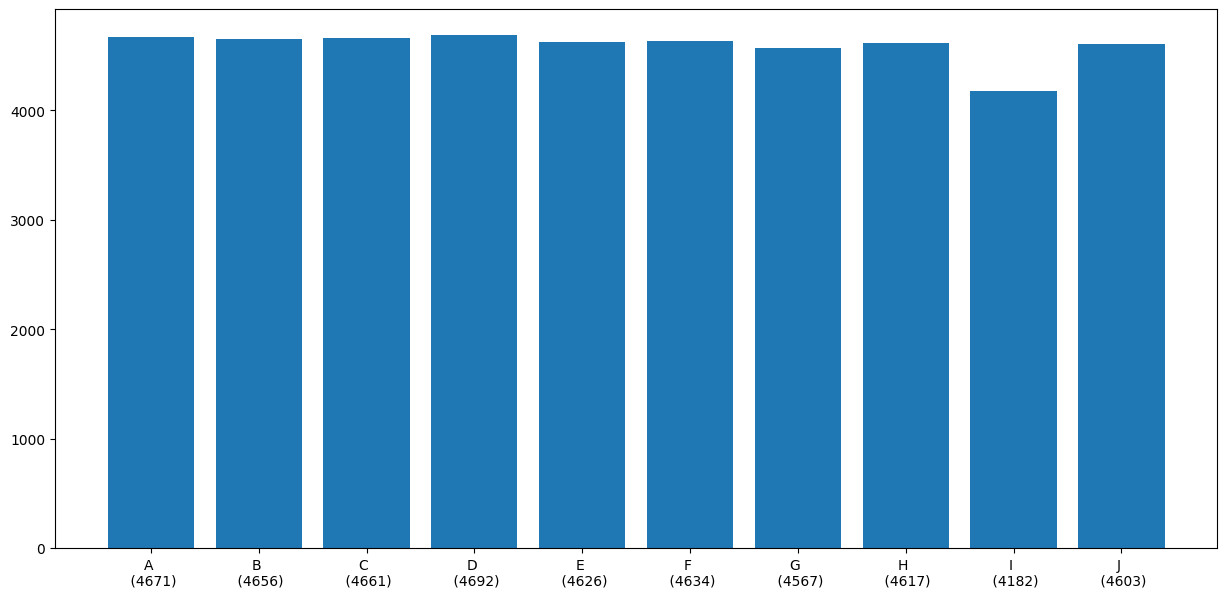

Variance for validation sample is: 411.0400000000001


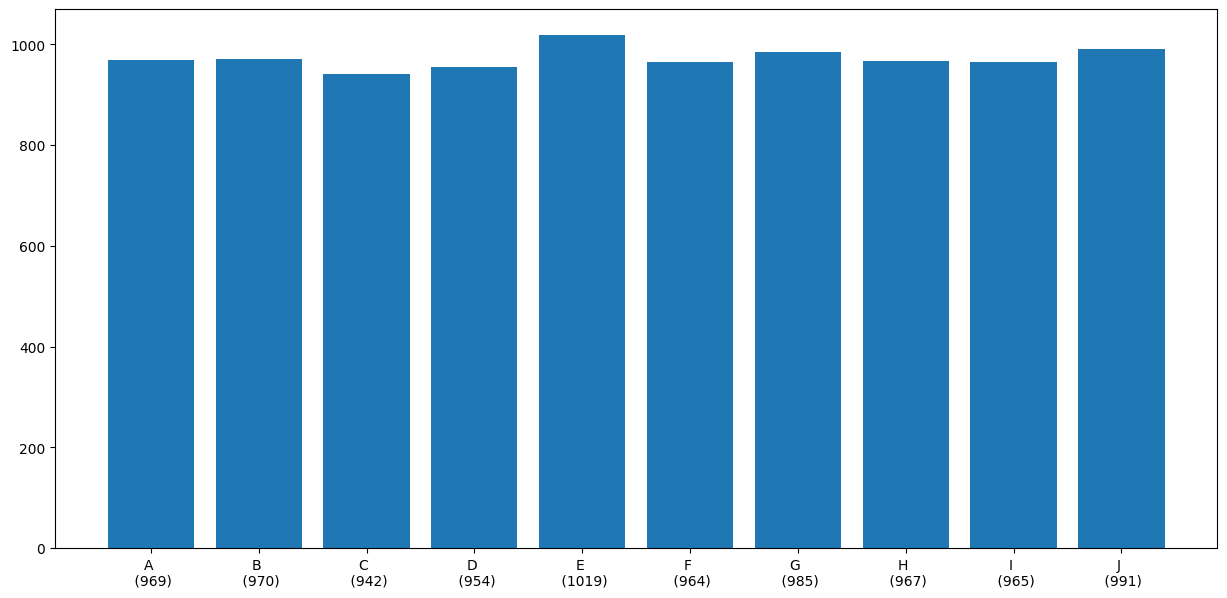

Variance for test sample is: 2696.56


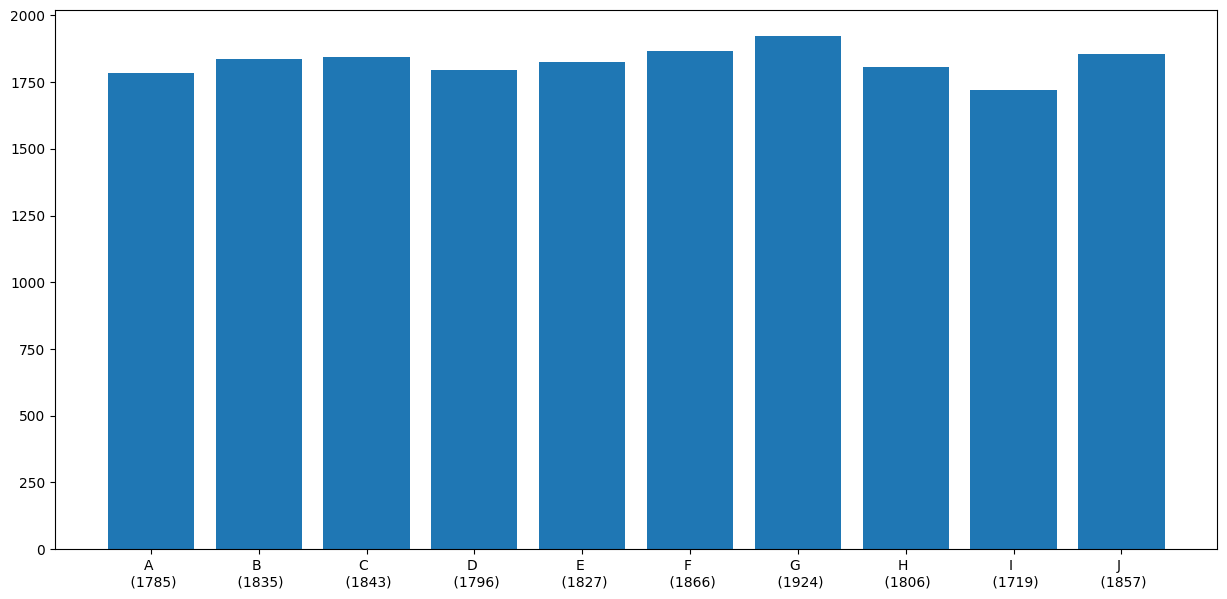

In [6]:
def get_class_counts(labels):
    labels_df = pd.DataFrame.from_dict({'letter': labels})
    counter_df = labels_df.groupby(['letter'])['letter'].count().reset_index(name='count')
    letters = counter_df['letter'].tolist()
    letter_counts = counter_df['count'].tolist()

    result_dict = {letters[i]: letter_counts[i] for i in range(len(letters))}
    return result_dict

def show_bar_graph(plt_data_dict, sample_name):
    letter_count_labels = []
    letter_counts = []

    variance = np.var(list(plt_data_dict.values()))
    print(f'Variance for {sample_name} sample is: {variance}')

    for key in plt_data_dict.keys():
        letter_count_labels.append(f'{key} \n ({plt_data_dict[key]})')
        letter_counts.append(plt_data_dict[key])

    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(7)

    plt.bar(letter_count_labels, letter_counts)
    plt.show()

samples_data_list = [
    {'x': train_x, 'y': train_y, 'name': 'train', 'classes_dict': None},
    {'x': validation_x, 'y': validation_y, 'name': 'validation', 'classes_dict': None},
    {'x': test_x, 'y': test_y, 'name': 'test', 'classes_dict': None}
]

for i in range(len(samples_data_list)):
    sample_data = samples_data_list[i]
    plt_data_dict = get_class_counts(sample_data['y'])
    samples_data_list[i]['classes_dict'] = plt_data_dict
    show_bar_graph(plt_data_dict, sample_data['name'])

## 1.4. Balancing

Variance for train sample is: 0.0


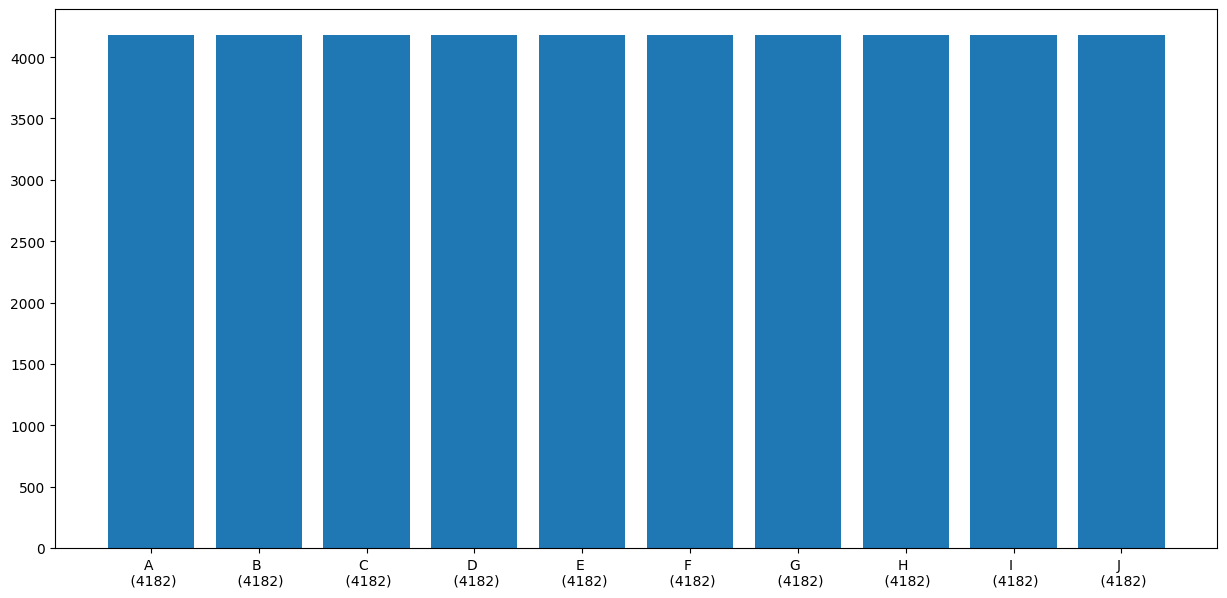

Variance for validation sample is: 0.0


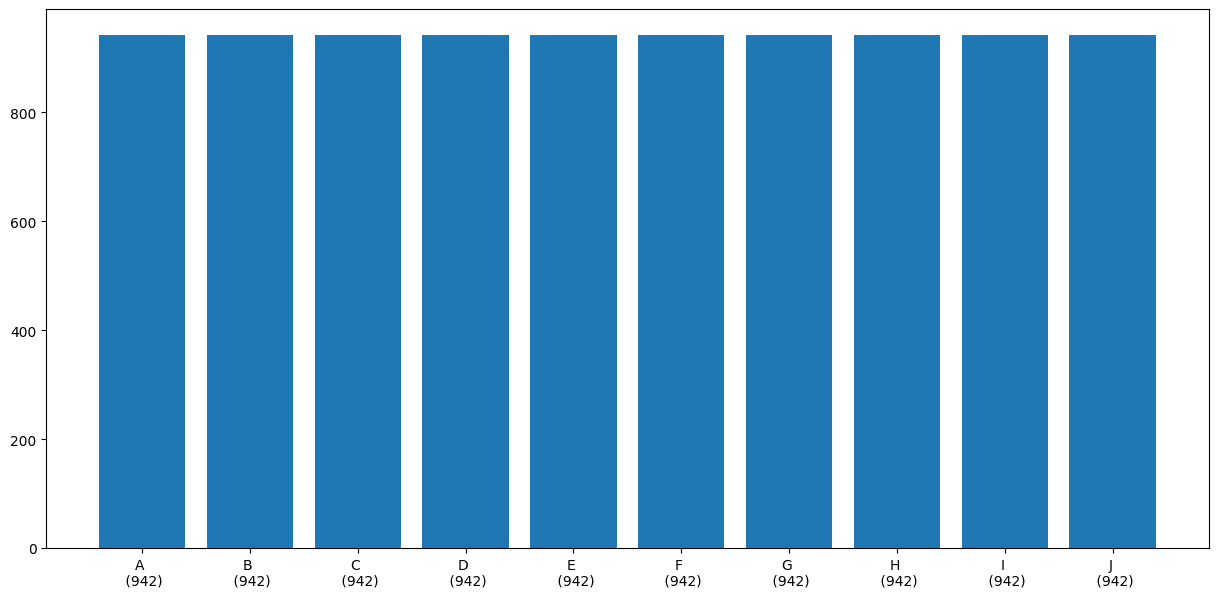

Variance for test sample is: 0.0


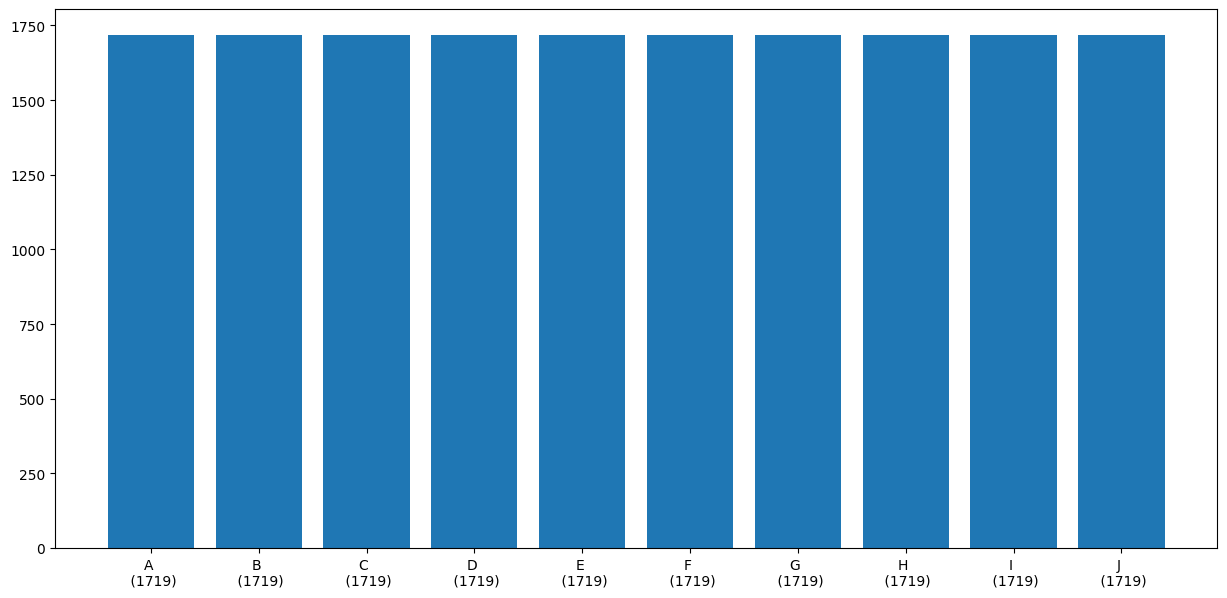

In [7]:
def balance_with_undersampling(x, y, classes_dict):
    min_class_count = min(list(classes_dict.values()))
    data = {'letter': y}
    df = pd.DataFrame.from_dict(data)
    df = df.reset_index()
    removed_idxs=[]
    for class_name in classes_dict.keys():
        deleted_count = classes_dict[class_name] - min_class_count
        if deleted_count > 0:
            class_df = (df.loc[df['letter'] == class_name]).head(deleted_count)
            removed_idxs += class_df['index'].tolist()
    unique_x = get_array_without_idxs(x, removed_idxs)
    unique_y = get_array_without_idxs(y, removed_idxs)
    return unique_x, unique_y


for i in range(len(samples_data_list)):
    sample_data = samples_data_list[i]
    x, y, classes_dict = sample_data['x'], sample_data['y'], sample_data['classes_dict']
    samples_data_list[i]['x'], samples_data_list[i]['y'] = balance_with_undersampling(x, y, classes_dict)

for i in range(len(samples_data_list)):
    sample_data = samples_data_list[i]
    plt_data_dict = get_class_counts(sample_data['y'])
    samples_data_list[i]['classes_dict'] = plt_data_dict
    show_bar_graph(plt_data_dict, sample_data['name'])

In [8]:
def prepare_data(x, y):
    images = [elem.tolist() for elem in x]
    labels = [ord(elem) - ord('A') for elem in y]
    return images, labels

for i in range(len(samples_data_list)):
    x, y = samples_data_list[i]['x'], samples_data_list[i]['y']
    samples_data_list[i]['x'], samples_data_list[i]['y'] = prepare_data(x, y)

    print(f'Data for {samples_data_list[i]["name"]} sample: x_count:{len(samples_data_list[i]["x"])}; y_count: {len(samples_data_list[i]["y"])}')

Data for train sample: x_count:41820; y_count: 41820
Data for validation sample: x_count:9420; y_count: 9420
Data for test sample: x_count:17190; y_count: 17190


# 2. Neural networks creating

In [9]:
epochs = 50
neurons_list = [510, 510, 250, 200, 150]
activation_funcs = {'piecewise_linear': tf.nn.relu, 'sigmoid': tf.nn.sigmoid ,'hyperbolic_tangent': tf.nn.tanh}
optimizer = tf.optimizers.SGD()
output_layer = keras.layers.Dense(10, activation=tf.nn.softmax)

## 2.1. Simple model

In [10]:
def get_simple_model_by_func_name(func_name):
    layers_list = [keras.layers.Dense(n, activation=activation_funcs[func_name]) for n in neurons_list]
    layers_list.append(output_layer)
    simple_model = keras.Sequential(layers_list)
    simple_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return simple_model

## 2.2. Regularized model

In [11]:
regularization_rate = 1e-3


def get_regularized_model_by_func_name(func_name):
    layers_list = [keras.layers.Dense(n, activation=activation_funcs[func_name], kernel_regularizer=keras.regularizers.l2(regularization_rate)) for n in neurons_list]
    layers_list.append(output_layer)
    regularized_model = keras.Sequential(layers_list)
    regularized_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return regularized_model

## 2.3. Dropout model

In [12]:
dropout_rate = 0.4


def get_dropout_model_by_func_name(func_name):
    layers_list = []
    for n in neurons_list:
        layers_list.append(keras.layers.Dense(n, activation=activation_funcs[func_name], kernel_regularizer=keras.regularizers.l2(regularization_rate)))
        layers_list.append(keras.layers.Dropout(dropout_rate))
    layers_list.append(output_layer)
    dropout_model = keras.Sequential(layers_list)
    dropout_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return dropout_model

## 2.4. Dynamic rate madel

In [13]:
def get_dynamic_rate_model_by_func_name(func_name):
    layers_list = []
    for n in neurons_list:
        layers_list.append(keras.layers.Dense(n, activation=activation_funcs[func_name], kernel_regularizer=keras.regularizers.l2(regularization_rate)))
        layers_list.append(keras.layers.Dropout(dropout_rate))
    layers_list.append(output_layer)
    dynamic_rate_model = keras.Sequential(layers_list)
    dynamic_rate_model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return dynamic_rate_model

## 2.5. Train and test functions

In [14]:
def train_model(model, x, y, epochs_count):
    history = model.fit(x, y, epochs=epochs_count)
    return model, history


def test_model(model, x, y):
    losses, accuracies = model.evaluate(x, y)
    return losses, accuracies

# 3. Validation for choose the best activation function

In this section validation sample will be used for choose the best activation function for each model according to received accuracy result for each function

In [15]:
validation_sample_data = list(filter(lambda elem: elem['name'] == 'validation', samples_data_list))[0]
train_sample_data = list(filter(lambda elem: elem['name'] == 'train', samples_data_list))[0]
test_sample_data = list(filter(lambda elem: elem['name'] == 'test', samples_data_list))[0]

validation_x, validation_y = validation_sample_data['x'], validation_sample_data['y']
train_x, train_y = train_sample_data['x'], train_sample_data['y']
test_x, test_y = test_sample_data['x'], test_sample_data['y']

In [16]:
def validate_with_functions(create_func):
    accur_to_func_map = {}
    histories = {}

    for func_name in activation_funcs.keys():
        model = create_func(func_name)
        trained_model, history = train_model(model, train_x, train_y, epochs)
        accuracy, loss = test_model(trained_model, validation_x, validation_y)
        accur_to_func_map[accuracy] = func_name
        histories[func_name] = history

    best_accur = max(list(accur_to_func_map.keys()))
    returned_model = create_func(accur_to_func_map[best_accur])

    return returned_model, histories

In [17]:
def show_activation_funcs_plot(title, histories):
    epochs_axis = [x for x in range(epochs)]
    for key in activation_funcs.keys():
        plt.plot(epochs_axis, histories[key].history['accuracy'], label=key)
        print(f'Max accuracy for {key} function is {max(histories[key].history["accuracy"])}')
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [18]:
simple_model, histories = validate_with_functions(get_simple_model_by_func_name)

Epoch 1/50
1307/1307 [==============================] - 19s 10ms/step - loss: 0.8543 - accuracy: 0.7648
Epoch 2/50
1307/1307 [==============================] - 14s 10ms/step - loss: 0.5515 - accuracy: 0.8398
Epoch 3/50
1307/1307 [==============================] - 14s 10ms/step - loss: 0.4945 - accuracy: 0.8549
Epoch 4/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.4547 - accuracy: 0.8657
Epoch 5/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.4231 - accuracy: 0.8743
Epoch 6/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.3949 - accuracy: 0.8816
Epoch 7/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.3684 - accuracy: 0.8910
Epoch 8/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.3445 - accuracy: 0.8973
Epoch 9/50
1307/1307 [==============================] - 13s 10ms/step - loss: 0.3211 - accuracy: 0.9041
Epoch 10/50
1307/1307 [==============================] - 14s 11m

Max accuracy for piecewise_linear function is 0.9979196786880493
Max accuracy for sigmoid function is 0.8042563199996948
Max accuracy for hyperbolic_tangent function is 0.9983022212982178


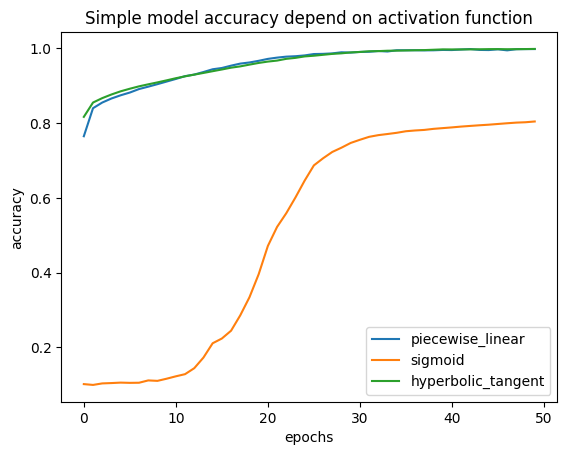

In [19]:
show_activation_funcs_plot('Simple model accuracy depend on activation function', histories)

In [20]:
regularized_model, histories = validate_with_functions(get_regularized_model_by_func_name)

Epoch 1/50
1307/1307 [==============================] - 20s 12ms/step - loss: 2.4798 - accuracy: 0.8067
Epoch 2/50
1307/1307 [==============================] - 16s 12ms/step - loss: 2.2217 - accuracy: 0.8535
Epoch 3/50
1307/1307 [==============================] - 16s 12ms/step - loss: 2.0871 - accuracy: 0.8686
Epoch 4/50
1307/1307 [==============================] - 15s 12ms/step - loss: 1.9715 - accuracy: 0.8813
Epoch 5/50
1307/1307 [==============================] - 15s 11ms/step - loss: 1.8686 - accuracy: 0.8901
Epoch 6/50
1307/1307 [==============================] - 15s 11ms/step - loss: 1.7753 - accuracy: 0.8971
Epoch 7/50
1307/1307 [==============================] - 15s 11ms/step - loss: 1.6877 - accuracy: 0.9054
Epoch 8/50
1307/1307 [==============================] - 15s 11ms/step - loss: 1.6072 - accuracy: 0.9115
Epoch 9/50
1307/1307 [==============================] - 16s 12ms/step - loss: 1.5286 - accuracy: 0.9187
Epoch 10/50
1307/1307 [==============================] - 15s 11m

Max accuracy for piecewise_linear function is 0.9894070029258728
Max accuracy for sigmoid function is 0.795791506767273
Max accuracy for hyperbolic_tangent function is 0.9350310564041138


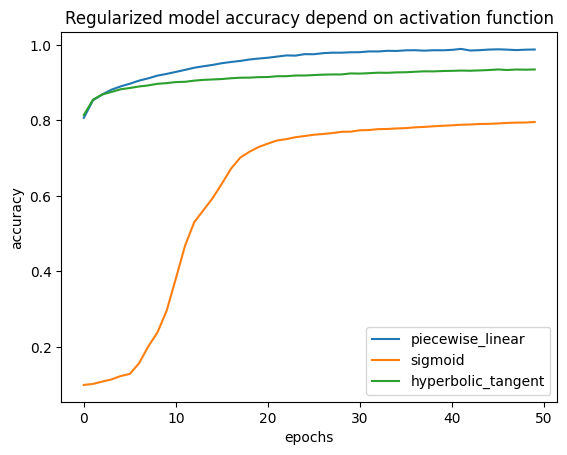

In [21]:
show_activation_funcs_plot('Regularized model accuracy depend on activation function', histories)

In [22]:
dropout_model, histories = validate_with_functions(get_dropout_model_by_func_name)

Epoch 1/50
1307/1307 [==============================] - 21s 13ms/step - loss: 3.3086 - accuracy: 0.4755
Epoch 2/50
1307/1307 [==============================] - 18s 14ms/step - loss: 2.5527 - accuracy: 0.7478
Epoch 3/50
1307/1307 [==============================] - 18s 14ms/step - loss: 2.3440 - accuracy: 0.7950
Epoch 4/50
1307/1307 [==============================] - 19s 15ms/step - loss: 2.2001 - accuracy: 0.8146
Epoch 5/50
1307/1307 [==============================] - 18s 14ms/step - loss: 2.0924 - accuracy: 0.8246
Epoch 6/50
1307/1307 [==============================] - 18s 14ms/step - loss: 1.9914 - accuracy: 0.8317
Epoch 7/50
1307/1307 [==============================] - 18s 14ms/step - loss: 1.9009 - accuracy: 0.8377
Epoch 8/50
1307/1307 [==============================] - 20s 15ms/step - loss: 1.8100 - accuracy: 0.8456
Epoch 9/50
1307/1307 [==============================] - 18s 14ms/step - loss: 1.7343 - accuracy: 0.8504
Epoch 10/50
1307/1307 [==============================] - 20s 15m

Max accuracy for piecewise_linear function is 0.9169297218322754
Max accuracy for sigmoid function is 0.10284552723169327
Max accuracy for hyperbolic_tangent function is 0.8515781760215759


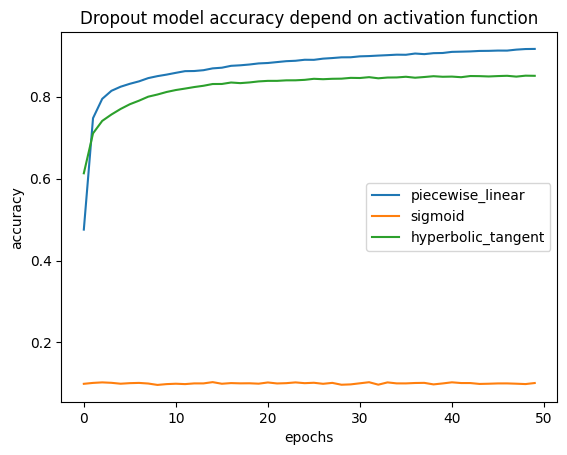

In [23]:
show_activation_funcs_plot('Dropout model accuracy depend on activation function', histories)

In [24]:
dynamic_rate_model, histories = validate_with_functions(get_dynamic_rate_model_by_func_name)

Epoch 1/50
1307/1307 [==============================] - 24s 15ms/step - loss: 2.1439 - accuracy: 0.6762
Epoch 2/50
1307/1307 [==============================] - 20s 15ms/step - loss: 1.1815 - accuracy: 0.8011
Epoch 3/50
1307/1307 [==============================] - 23s 18ms/step - loss: 0.9881 - accuracy: 0.8083
Epoch 4/50
1307/1307 [==============================] - 20s 15ms/step - loss: 0.9249 - accuracy: 0.8145
Epoch 5/50
1307/1307 [==============================] - 21s 16ms/step - loss: 0.9185 - accuracy: 0.8137
Epoch 6/50
1307/1307 [==============================] - 31s 23ms/step - loss: 0.9054 - accuracy: 0.8153
Epoch 7/50
1307/1307 [==============================] - 26s 20ms/step - loss: 0.9028 - accuracy: 0.8154
Epoch 8/50
1307/1307 [==============================] - 23s 18ms/step - loss: 0.9026 - accuracy: 0.8162
Epoch 9/50
1307/1307 [==============================] - 21s 16ms/step - loss: 0.8893 - accuracy: 0.8198
Epoch 10/50
1307/1307 [==============================] - 22s 17m

Max accuracy for piecewise_linear function is 0.8240076303482056
Max accuracy for sigmoid function is 0.10251075774431229
Max accuracy for hyperbolic_tangent function is 0.8081061840057373


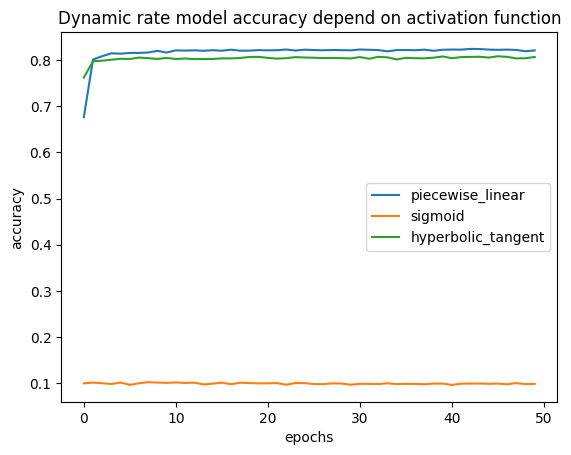

In [25]:
show_activation_funcs_plot('Dynamic rate model accuracy depend on activation function', histories)

Validation results shows, that piecewise linear function is the best activation function

# 4. Train and test models

In [34]:
models_map = {
    'simple': {
        'model': get_simple_model_by_func_name('piecewise_linear'),
        'history': None,
        'accuracies': None,
        'losses': None,
    },
    'regularized': {
        'model': get_regularized_model_by_func_name('piecewise_linear'),
        'history': None,
        'accuracies': None,
        'losses': None,
    },
    'dropout': {
        'model': get_dropout_model_by_func_name('piecewise_linear'),
        'history': None,
        'accuracies': None,
        'losses': None,
    },
    'dynamic_rate': {
        'model': get_dynamic_rate_model_by_func_name('piecewise_linear'),
        'history': None,
        'accuracies': None,
        'losses': None,
    }
}

In [35]:
for key in models_map.keys():
    model = models_map[key]['model']
    trained_model, history = train_model(model, train_x, train_y, epochs)
    models_map[key]['history'] = history
    losses, accuracies = test_model(trained_model, test_x, test_y)
    models_map[key]['accuracies'] = accuracies
    models_map[key]['losses'] = losses

Epoch 1/50
1307/1307 [==============================] - 42s 12ms/step - loss: 0.7783 - accuracy: 0.7806
Epoch 2/50
1307/1307 [==============================] - 17s 13ms/step - loss: 0.5322 - accuracy: 0.8451
Epoch 3/50
1307/1307 [==============================] - 17s 13ms/step - loss: 0.4788 - accuracy: 0.8593
Epoch 4/50
1307/1307 [==============================] - 17s 13ms/step - loss: 0.4394 - accuracy: 0.8695
Epoch 5/50
1307/1307 [==============================] - 18s 14ms/step - loss: 0.4081 - accuracy: 0.8784
Epoch 6/50
1307/1307 [==============================] - 17s 13ms/step - loss: 0.3797 - accuracy: 0.8862
Epoch 7/50
1307/1307 [==============================] - 17s 13ms/step - loss: 0.3522 - accuracy: 0.8937
Epoch 8/50
1307/1307 [==============================] - 18s 13ms/step - loss: 0.3268 - accuracy: 0.9021
Epoch 9/50
1307/1307 [==============================] - 16s 12ms/step - loss: 0.3018 - accuracy: 0.9096
Epoch 10/50
1307/1307 [==============================] - 17s 13m

Accuracy for simple model: 0.8953461050987244
Accuracy for regularized model: 0.8938336372375488
Accuracy for dropout model: 0.892728328704834
Accuracy for dynamic_rate model: 0.8459569811820984


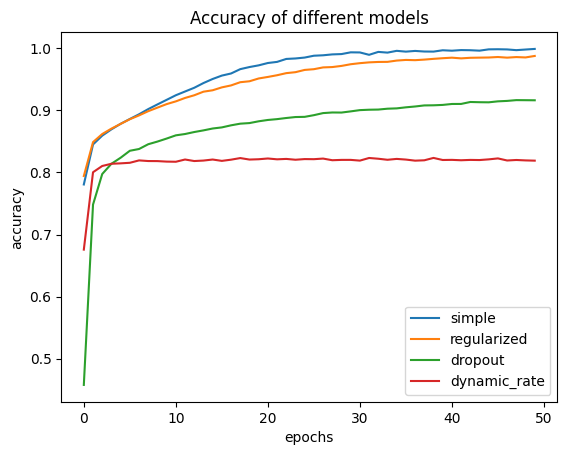

In [36]:
epochs_axis = [x for x in range(epochs)]

for key in models_map.keys():
        plt.plot(epochs_axis, models_map[key]['history'].history['accuracy'], label=key)
        print(f'Accuracy for {key} model: {models_map[key]["accuracies"]}')

plt.title('Accuracy of different models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Losses for simple model: 0.8095285296440125
Losses for regularized model: 0.7901548147201538
Losses for dropout model: 0.6401188373565674
Losses for dynamic_rate model: 0.7384322285652161


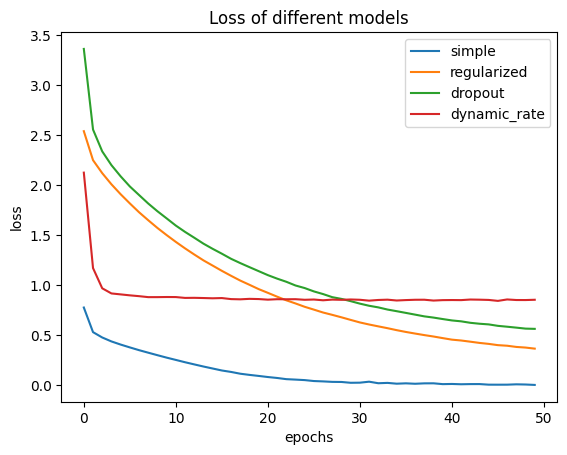

In [37]:
for key in models_map.keys():
        plt.plot(epochs_axis, models_map[key]['history'].history['loss'], label=key)
        print(f'Losses for {key} model: {models_map[key]["losses"]}')

plt.title('Loss of different models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()